In [1]:
from fastai.vision import *

It seems that the data_block API `label_from_df` treats NaNs in a different way to what we would want. Let's monkey patch `ItemList` and implement the behavior that we want!

The problem lies in the fact that when you read a csv file into a pandas DataFrame it will substitute blank fields with `NaN`.

In [2]:
df = pd.read_csv('data/train_labels_as_strings.csv')

In [3]:
df.head()

,fn,labels
0,ID_63eb1e259.png,NaN
1,ID_2669954a7.png,NaN
2,ID_52c9913b1.png,NaN
3,ID_4e6ff6126.png,NaN
4,ID_7858edd88.png,NaN


`NaN` values will prevent `ItemList.label_from_df` from giving us correct labels. Let's fill in the `NaN` values with an empty string.

In [4]:
df.labels.fillna('', inplace=True)
df.head()

,fn,labels
0,ID_63eb1e259.png,
1,ID_2669954a7.png,
2,ID_52c9913b1.png,
3,ID_4e6ff6126.png,
4,ID_7858edd88.png,


In [5]:
from fastai.data_block import _maybe_squeeze

In [6]:
def modified_label_from_df(self, cols:IntsOrStrs=1, label_cls:Callable=None, **kwargs):
    "Label `self.items` from the values in `cols` in `self.inner_df`."
    self.inner_df.labels.fillna('', inplace=True)
    labels = self.inner_df.iloc[:,df_names_to_idx(cols, self.inner_df)]
    assert labels.isna().sum().sum() == 0, f"You have NaN values in column(s) {cols} of your dataframe, please fix it."
    if is_listy(cols) and len(cols) > 1 and (label_cls is None or label_cls == MultiCategoryList):
        new_kwargs,label_cls = dict(one_hot=True, classes= cols),MultiCategoryList
        kwargs = {**new_kwargs, **kwargs}
    return self._label_from_list(_maybe_squeeze(labels), label_cls=label_cls, **kwargs)


In [7]:
ItemList.label_from_df = modified_label_from_df

In [8]:
sample_submission = pd.read_csv('data/stage_1_sample_submission.csv.zip')

In [9]:
sample_submission['fn'] = sample_submission.ID.apply(lambda x: '_'.join(x.split('_')[:2]) + '.png')

In [10]:
sample_submission.head()

,ID,Label,fn
0,ID_28fbab7eb_epidural,0.5,ID_28fbab7eb.png
1,ID_28fbab7eb_intraparenchymal,0.5,ID_28fbab7eb.png
2,ID_28fbab7eb_intraventricular,0.5,ID_28fbab7eb.png
3,ID_28fbab7eb_subarachnoid,0.5,ID_28fbab7eb.png
4,ID_28fbab7eb_subdural,0.5,ID_28fbab7eb.png


In [11]:
test_fns = sample_submission.fn.unique()

In [12]:
data = (ImageList.from_csv('data', 'train_labels_as_strings.csv', folder='112/train')
        .split_by_rand_pct()
        .label_from_df(label_delim=' ')
        .add_test('data/112/test/' + test_fns)
        .databunch(bs=128))                          

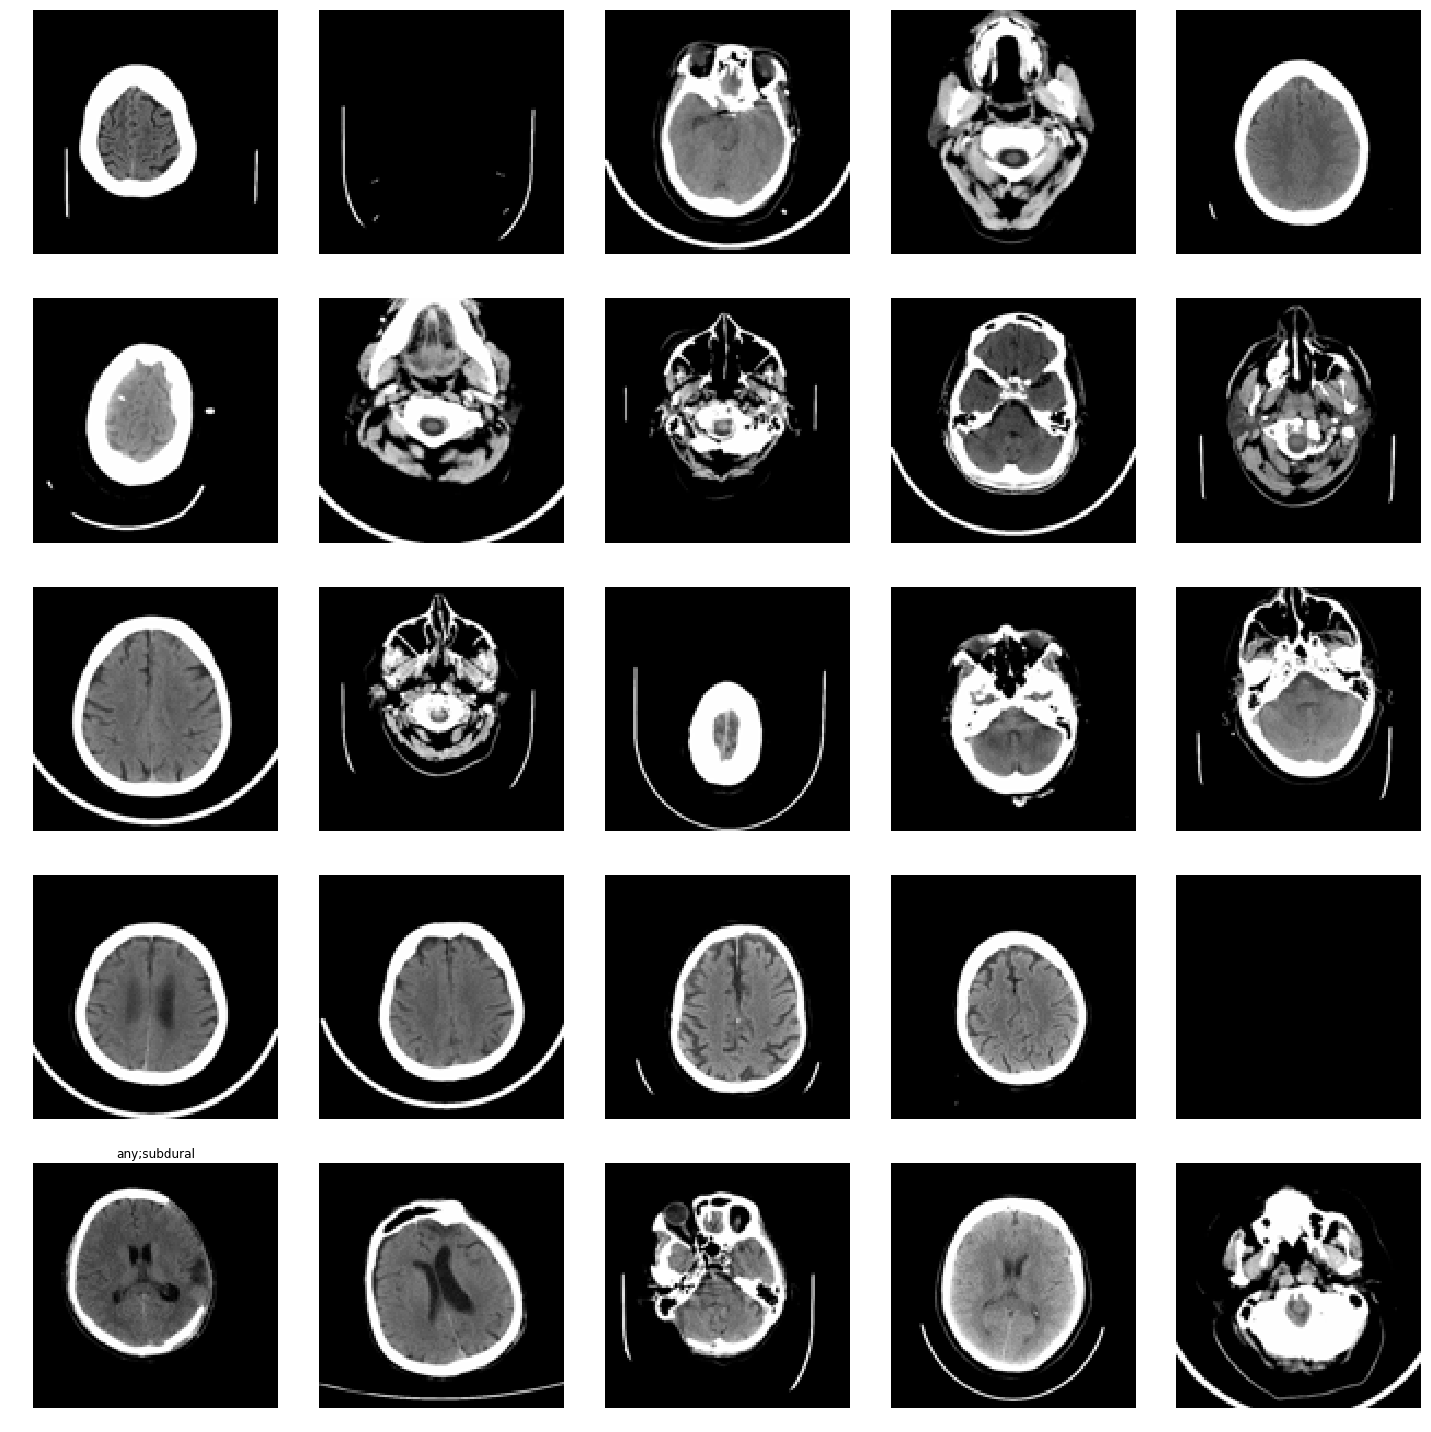

In [13]:
data.show_batch()

In [14]:
learn = cnn_learner(data, models.resnet18, metrics=[accuracy_thresh])

In [17]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


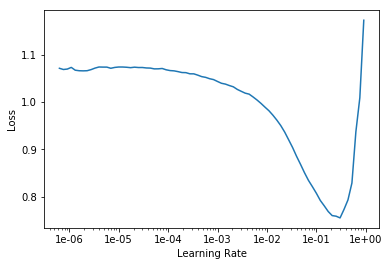

In [18]:
learn.recorder.plot()

In [19]:
learn.fit_one_cycle(1, 2e-2)

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.113111,0.114082,0.959257,03:39


In [20]:
learn.save('phase-1')

In [21]:
learn.load('phase-1');

In [22]:
learn.freeze_to(-2)

In [23]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


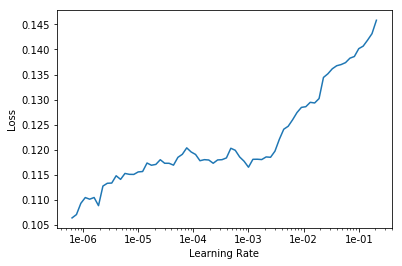

In [24]:
learn.recorder.plot()

In [25]:
learn.fit_one_cycle(1, 1e-3)

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.103857,0.103774,0.962361,04:15


In [26]:
learn.save('phase-2')

In [27]:
learn.load('phase-2');

In [28]:
learn.unfreeze()

In [29]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


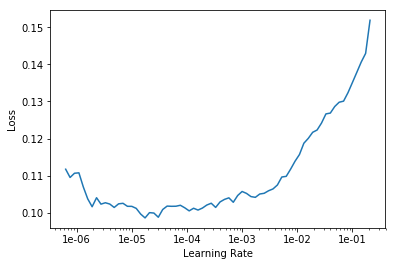

In [30]:
learn.recorder.plot()

In [31]:
learn.fit_one_cycle(1, [1e-4, 5e-4, 1e-3])

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.097098,0.094363,0.965728,04:49


In [32]:
learn.save('phase-3')

In [33]:
learn.load('phase-3');

In [34]:
preds, targs = learn.get_preds(DatasetType.Test)

In [35]:
ids = []
labels = []

for fn, pred in zip(test_fns, preds):
    for i, label in enumerate(data.train_ds.classes):
        ids.append(f"{fn.split('.')[0]}_{label}")
        predicted_probability = '{0:1.10f}'.format(pred[i].item())
        labels.append(predicted_probability)

In [36]:
mkdir -p data/submissions

In [36]:
sub_name = 'resnet-18_starter_pack'
pd.DataFrame({'ID': ids, 'Label': labels}).to_csv(f'data/submissions/{sub_name}.csv.zip', compression='zip', index=False)

In [37]:
!kaggle competitions submit -c rsna-intracranial-hemorrhage-detection -f data/submissions/{sub_name}.csv.zip -m {sub_name}

100%|███████████████████████████████████████| 4.25M/4.25M [00:05<00:00, 794kB/s]
Successfully submitted to RSNA Intracranial Hemorrhage Detection